In [13]:
%pylab inline

import networkx as nx
import scipy.sparse
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance

from regain import datasets
from regain.datasets import is_pos_def, is_pos_semidef
from regain.plot import plot_graph_with_latent_variables
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_v2_; reload(latent_time_graph_lasso_v2_)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);

Populating the interactive namespace from numpy and matplotlib


In [14]:
import pandas as pd
data = pd.read_csv("/home/fede/src/slipguru/regain/regain/data/gene_chandrasekaran.csv").values.T

In [15]:
C = loadmat("../regain/data/X_output_chandra.mat")['X1']
C2 = loadmat("../regain/data/X2_output_chandra.mat")['X2']
out_B = loadmat("../regain/data/out_B.mat")
Sigma0 = loadmat("../regain/data/Sigma0.mat")['SigmaO']

In [16]:
# config
n_samples = 100
n_dim_obs = 10
n_dim_lat = 2
T = 10

data_list, K, K_obs, ells = datasets.generate_dataset(
        mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat,
        n_dim_obs=n_dim_obs, T=1)

## 1. Single timestamp
Check if, with only one timestamp, the method behave the same as Chandrasekaran/Ma.

In [17]:
emp_cov = empirical_covariance(data_list[0], assume_centered=False)

### 1.1 Do we behave as ourselves with the same functional as Ma?
The following is the latent time graphical model inference with only one covariance matrix.

In [18]:
results_time = latent_time_graph_lasso_.latent_time_graph_lasso(
        np.array([emp_cov]), alpha=0.05, tau=0.25,
        tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
        verbose=0, max_iter=500)

We compare it with the code for the latent graphical model inference (without time). <br>
Since there is only one covariance matrix, we expect to obtain the same results.

In [19]:
results_static = latent_graph_lasso_.latent_graph_lasso(
    emp_cov, alpha=0.05, tau=0.25, tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
    verbose=0, max_iter=500)

In [20]:
assert np.all([np.allclose(x, y) for x, y in zip(results_static, results_time)])

Now we check if the result is the same as the Chandrasekaran/Ma Matlab algorithm. To do that, we load `pymatbridge`, to run Matlab code directly from Jupyter notebook.

In [21]:
%load_ext pymatbridge
%matlab cd /home/fede/Downloads/lvglasso-pub/

/home/fede/miniconda2/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-a045c39b-77f8-404a-aaff-8322f68e0c32
Send 'exit' command to kill the server
.......MATLAB started and connected!


In [48]:
%%matlab -i emp_cov -o R,S,L,obj,res,iter
alpha = 0.05;
beta = 0.25; %beta here is tau

opts.continuation = 1; opts.num_continuation = 10;
opts.eta = 1; opts.muf = 1e-6;
opts.maxiter = 500; opts.stoptol = 1e-5; 
opts.over_relax_par = 1;
n = size(emp_cov,1); opts.mu = n;

tic; out_B = ADMM_B(emp_cov,alpha,beta,opts); solve_B = toc;
%%fprintf('ADMM_B: obj: %e, iter: %d, cpu: %3.1f \n',out_B.obj,out_B.iter,solve_B);

R = out_B.R;
S = out_B.S;
L = out_B.L;
obj = out_B.obj;
res = out_B.resid;
iter = out_B.iter;

In [49]:
assert np.all([np.allclose(x, y, atol=1e-4) for x, y in zip(results_static[:-1], (S, L))])

## 2. Time-varying vs separate for each time
This is to justify the choice of the additional penalties which constrain subsequent matrices in time to behave similarly.

In [76]:
# config
n_samples = 100
n_dim_obs = 3
n_dim_lat = 1
T = 10

data_list, K, K_obs, ells = datasets.generate_dataset(
    mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=n_dim_obs, T=T)

data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

First, we check again if the results are the same with beta and eta is 0.

In [77]:
emp_cov = np.array([empirical_covariance(data, assume_centered=False) for data in data_list])
emp_list = np.array(emp_cov).transpose(1,2,0)

In [110]:
reload(latent_time_graph_lasso_)
results_time = latent_time_graph_lasso_.latent_time_graph_lasso(
    emp_cov, alpha=0.05, tau=0.25, tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    beta=0, eta=0,
    verbose=0, max_iter=500)

Z_0 [[[ 0.4501499   0.          0.        ]
  [ 0.          0.43938231  0.        ]
  [ 0.          0.          0.33744381]]

 [[ 0.41500275  0.          0.        ]
  [ 0.          0.69043087  0.        ]
  [ 0.          0.          0.32920784]]

 [[ 0.34999306  0.          0.        ]
  [ 0.          0.54414312  0.        ]
  [ 0.          0.          0.41883014]]

 [[ 0.42404828  0.          0.        ]
  [ 0.          0.43001171  0.        ]
  [ 0.          0.          0.43978867]]

 [[ 0.52336429  0.          0.        ]
  [ 0.          0.36676387  0.        ]
  [ 0.          0.          0.54262234]]

 [[ 0.4620838   0.          0.        ]
  [ 0.          0.61191901  0.        ]
  [ 0.          0.          0.72799693]]

 [[ 0.38455518  0.          0.        ]
  [ 0.          0.50126675  0.        ]
  [ 0.          0.          0.52054993]]

 [[ 0.62657805  0.          0.        ]
  [ 0.          0.54993694  0.        ]
  [ 0.          0.          0.44589652]]

 [[ 0.64571968  0.  

Z_1 [[[ 0.97763611  0.17124831  0.03283751]
  [ 0.17124831  0.96066802  0.09584596]
  [ 0.03283751  0.09584596  0.85095171]]

 [[ 0.93559787  0.19293341  0.0794911 ]
  [ 0.19293341  1.2690252   0.38856298]
  [ 0.0794911   0.38856298  0.84632708]]

 [[ 0.8626946   0.08480795  0.08812186]
  [ 0.08480795  1.08589181  0.27203957]
  [ 0.08812186  0.27203957  0.93855644]]

 [[ 0.94026384  0.16333317  0.22705818]
  [ 0.16333317  0.94979452  0.11673216]
  [ 0.22705818  0.11673216  0.96028511]]

 [[ 1.05929214  0.13403354  0.17348208]
  [ 0.13403354  0.877543    0.2382185 ]
  [ 0.17348208  0.2382185   1.07984498]]

 [[ 0.98941013  0.10913684  0.24671073]
  [ 0.10913684  1.17142648  0.25815942]
  [ 0.24671073  0.25815942  1.31699762]]

 [[ 0.90120935  0.05279917  0.22133416]
  [ 0.05279917  1.03694787  0.20463497]
  [ 0.22133416  0.20463497  1.05203659]]

 [[ 1.19340885  0.1154259   0.05261879]
  [ 0.1154259   1.09337622  0.12023244]
  [ 0.05261879  0.12023244  0.97261444]]

 [[ 1.22252668  0.  

  [ 0.26983526  0.14531862  0.78975629]]]
Z_1 [[[ 0.97763611  0.17124831  0.03283751]
  [ 0.17124831  0.96066802  0.09584596]
  [ 0.03283751  0.09584596  0.85095171]]

 [[ 0.93559787  0.19293341  0.0794911 ]
  [ 0.19293341  1.2690252   0.38856298]
  [ 0.0794911   0.38856298  0.84632708]]

 [[ 0.8626946   0.08480795  0.08812186]
  [ 0.08480795  1.08589181  0.27203957]
  [ 0.08812186  0.27203957  0.93855644]]

 [[ 0.94026384  0.16333317  0.22705818]
  [ 0.16333317  0.94979452  0.11673216]
  [ 0.22705818  0.11673216  0.96028511]]

 [[ 1.05929214  0.13403354  0.17348208]
  [ 0.13403354  0.877543    0.2382185 ]
  [ 0.17348208  0.2382185   1.07984498]]

 [[ 0.98941013  0.10913684  0.24671073]
  [ 0.10913684  1.17142648  0.25815942]
  [ 0.24671073  0.25815942  1.31699762]]

 [[ 0.90120935  0.05279917  0.22133416]
  [ 0.05279917  1.03694787  0.20463497]
  [ 0.22133416  0.20463497  1.05203659]]

 [[ 1.19340885  0.1154259   0.05261879]
  [ 0.1154259   1.09337622  0.12023244]
  [ 0.05261879  0.12

In [93]:
results_static = [latent_graph_lasso_.latent_graph_lasso(
    x, alpha=0.05, tau=0.25, tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
    verbose=0, max_iter=500) for x in emp_cov]

In [109]:
np.all([np.allclose(results_static[i][0], results_time[0][i], atol=1e-4) for i in range(10)])

True

In [106]:
results_static[i][0], results_time[0][i]

(array([[ 1.06999105,  0.12611868,  0.26983273],
        [ 0.12611868,  1.16941533,  0.14531558],
        [ 0.26983273,  0.14531558,  0.78975447]]),
 array([[ 1.06999455,  0.1261231 ,  0.26983526],
        [ 0.1261231 ,  1.16941957,  0.14531862],
        [ 0.26983526,  0.14531862,  0.78975629]]))

In [79]:
%%matlab -i emp_list -o R,S,L,obj,res,iter
alpha = 0.05;
beta = 0.25;
opts.continuation = 1; opts.num_continuation = 0;
opts.eta = 1; opts.muf = 1e-6;
opts.maxiter = 500; opts.stoptol = 1e-5; 
opts.over_relax_par = 1;

R = cell(1, size(emp_list,3));
S = cell(1, size(emp_list,3));
L = cell(1, size(emp_list,3));
obj = cell(1, size(emp_list,3));
res = cell(1, size(emp_list,3));
iter = cell(1, size(emp_list,3));
for i=1:size(emp_list,3)
    cov = emp_list(:,:,i);
    n = size(cov,1);opts.mu = n;
    tic; out_B = ADMM_B(cov,alpha,beta,opts); solve_B = toc;
    %%fprintf('ADMM_B: obj: %e, iter: %d, cpu: %3.1f \n',out_B.obj,out_B.iter,solve_B);
    R{i} = out_B.R;
    S{i} = out_B.S;
    L{i} = out_B.L;
    obj{i} = out_B.obj;
    res{i} = out_B.resid;
    iter{i} = out_B.iter;
end

In [80]:
RR = results_time[0]
R = np.array(R)

In [81]:
RR[np.abs(RR)<1e-4] = 0
R[np.abs(R)<1e-4] = 0

In [82]:
np.allclose(R, RR, atol=1e-4)

False

In [83]:
R

array([[[ 0.97763798,  0.17125164,  0.03283095],
        [ 0.17125164,  0.9606667 ,  0.09584755],
        [ 0.03283095,  0.09584755,  0.85095658]],

       [[ 0.93560056,  0.19293154,  0.07949323],
        [ 0.19293154,  1.26902676,  0.38855872],
        [ 0.07949323,  0.38855872,  0.84633747]],

       [[ 0.86268792,  0.08479719,  0.08811091],
        [ 0.08479719,  1.08588841,  0.27204515],
        [ 0.08811091,  0.27204515,  0.9385441 ]],

       [[ 0.94024941,  0.16332935,  0.22706254],
        [ 0.16332935,  0.94978815,  0.11671969],
        [ 0.22706254,  0.11671969,  0.9602744 ]],

       [[ 1.05929455,  0.13402355,  0.17347812],
        [ 0.13402355,  0.87752163,  0.23822247],
        [ 0.17347812,  0.23822247,  1.07984371]],

       [[ 0.9894049 ,  0.10913045,  0.24671077],
        [ 0.10913045,  1.17142919,  0.25815893],
        [ 0.24671077,  0.25815893,  1.31700135]],

       [[ 0.90120527,  0.05278368,  0.22134077],
        [ 0.05278368,  1.03694856,  0.2046389 ],
        

In [84]:
RR

array([[[ 1.0157778 ,  0.21087601,  0.06445586],
        [ 0.21087601,  1.00183991,  0.12869684],
        [ 0.06445586,  0.12869684,  0.8771638 ]],

       [[ 0.99254206,  0.28016383,  0.14144882],
        [ 0.28016383,  1.40264972,  0.48347338],
        [ 0.14144882,  0.48347338,  0.91373972]],

       [[ 0.90359459,  0.14178615,  0.13941221],
        [ 0.14178615,  1.1652687 ,  0.34349266],
        [ 0.13941221,  0.34349266,  1.00287675]],

       [[ 1.00801263,  0.22595008,  0.29345369],
        [ 0.22595008,  1.00766829,  0.1780983 ],
        [ 0.29345369,  0.1780983 ,  1.02535438]],

       [[ 1.13144463,  0.20000904,  0.25221935],
        [ 0.20000904,  0.93787033,  0.31021507],
        [ 0.25221935,  0.31021507,  1.16576797]],

       [[ 1.06095663,  0.19097257,  0.34360521],
        [ 0.19097257,  1.26503114,  0.36898844],
        [ 0.34360521,  0.36898844,  1.44822047]],

       [[ 0.95423455,  0.11119476,  0.28801386],
        [ 0.11119476,  1.10125778,  0.278068  ],
        

In [6]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain.admm.latent_time_graph_lasso_ import LatentTimeGraphLasso

ltgl = GridSearchCV(LatentTimeGraphLasso(bypass_transpose=False, assume_centered=False),
                    dict(tau=np.logspace(-1,0,2), eta=np.logspace(-1,0,2),
                         alpha=np.logspace(-1,1,2), beta=np.logspace(-1,1,2)),
                    cv=ShuffleSplit(10)).fit(data_grid)

/home/fede/src/slipguru/regain/regain/admm/latent_time_graph_lasso_.py:216: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [7]:
utils.error_norm(ltgl.best_estimator_.precision_, K)

0.20905545253065858

/home/fede/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


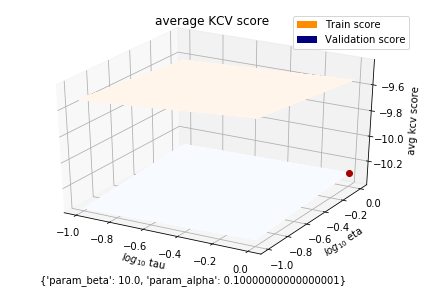

In [8]:
from palladio import plotting; reload(plotting);
plotting.score_surfaces_gridsearch(ltgl, indep_vars=['tau','eta'], logspace=['tau','eta'])

In [25]:
emp_list = list(ltgl.best_estimator_.covariance_)
alpha = ltgl.best_params_['alpha']
beta = ltgl.best_params_['beta']

In [26]:
%%matlab -i emp_list,alpha,beta -o R,S,L,obj,res,iter
%alpha = 0.05;
%beta = 0.25*100;
opts.continuation = 1; opts.num_continuation = 10;
opts.eta = 1; opts.muf = 1e-6;
opts.maxiter = 500; opts.stoptol = 1e-5; 
opts.over_relax_par = 1;

R = []; S = []; L=[];obj=[];res=[];iter=[];
for i=1:size(emp_list,3)
    cov = emp_list(:,:,i);
    n = size(cov,1);opts.mu = n;
    tic; out_B = ADMM_B(cov,alpha,beta,opts); solve_B = toc;
    %%fprintf('ADMM_B: obj: %e, iter: %d, cpu: %3.1f \n',out_B.obj,out_B.iter,solve_B);
    R = [R; out_B.R];
    S = [S; out_B.R];
    L = [L; out_B.R];
    obj = [obj; out_B.R];
    res = [res; out_B.resid];
    iter = [iter; out_B.iter];
end

In [27]:
R_ar = np.array([R[i*R.shape[1]:(i+1)*R.shape[1]] for i in range(R.shape[0]/R.shape[1])])
L_ar = np.array([L[i*L.shape[1]:(i+1)*L.shape[1]] for i in range(L.shape[0]/L.shape[1])])
K_obs = np.array(K_obs)

In [28]:
from regain.utils import error_norm
error_norm(ltgl.best_estimator_.precision_, K_obs)

0.20658908233474657

In [29]:
error_norm(R_ar, K_obs)

0.36722333283170749

In [15]:
K_obs

array([[[  9.88107604e-01,  -2.79945597e-03,  -3.89333887e-03,
           2.41379995e-01,   0.00000000e+00,   0.00000000e+00,
          -5.66045116e-04,   2.40315308e-01,  -1.36101252e-02,
          -1.28844196e-02],
        [ -2.79945597e-03,   9.98119363e-01,   0.00000000e+00,
           2.49003806e-01,   0.00000000e+00,   0.00000000e+00,
          -3.80261566e-04,   0.00000000e+00,   2.45134492e-01,
          -2.80797316e-03],
        [ -3.89333887e-03,   0.00000000e+00,   9.98037843e-01,
          -3.59694264e-03,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   2.45119129e-01,  -3.20907335e-03,
           2.45613093e-01],
        [  2.41379995e-01,   2.49003806e-01,  -3.59694264e-03,
           9.92878543e-01,   0.00000000e+00,   0.00000000e+00,
          -2.01428682e-04,  -8.94740545e-03,  -8.46004873e-03,
          -9.52930507e-03],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
      

In [30]:
ltgl.best_estimator_.precision_

array([[[  1.07499367e+00,   3.78256927e-03,  -7.86602478e-03,
           1.97250522e-01,   6.57040421e-02,  -3.55192759e-02,
           2.14109008e-04,   1.48854144e-01,  -2.93577230e-03,
           7.21839375e-02],
        [  3.78256927e-03,   1.10106319e+00,  -1.18914762e-02,
           1.39854107e-01,   1.34221723e-01,  -4.37161375e-03,
          -2.05097195e-03,   5.91697327e-03,   9.08893440e-02,
           1.61284008e-02],
        [ -7.86602478e-03,  -1.18914762e-02,   1.05605893e+00,
          -5.42013867e-02,  -9.54400299e-02,  -1.56380425e-02,
          -6.77115443e-03,   4.66831007e-02,  -7.68901430e-03,
           2.13947871e-01],
        [  1.97250522e-01,   1.39854107e-01,  -5.42013867e-02,
           1.06564209e+00,   2.11076414e-04,   1.28607605e-03,
          -1.26635492e-02,  -1.31319343e-03,  -1.09990975e-01,
           6.01706528e-03],
        [  6.57040421e-02,   1.34221723e-01,  -9.54400299e-02,
           2.11076414e-04,   1.07169639e+00,   2.07988018e-03,
      

In [244]:
R_ar

array([[[  1.68155334e-01,  -5.70861995e-04,   2.86500728e-03,
          -7.15924125e-04,  -6.80308340e-04,  -1.69732339e-03,
           4.63174738e-04,  -2.10009828e-04,   7.80229452e-04,
           5.44973011e-04],
        [ -5.70861995e-04,   1.70425528e-01,   3.16615216e-04,
          -1.73644882e-04,  -1.55609769e-03,  -1.02630323e-04,
           2.65004659e-03,  -5.28134878e-04,   2.00007910e-03,
          -3.05268671e-04],
        [  2.86500728e-03,   3.16615216e-04,   1.70086854e-01,
           2.00991221e-04,   1.05920048e-03,   1.99204658e-03,
          -6.85897176e-04,   3.99848209e-05,  -1.21298732e-03,
          -3.04487271e-04],
        [ -7.15924125e-04,  -1.73644882e-04,   2.00991221e-04,
           1.70859642e-01,   3.95704402e-05,   1.19796868e-03,
           1.01112265e-04,  -1.40823993e-04,   2.19897531e-04,
           2.30347512e-03],
        [ -6.80308340e-04,  -1.55609769e-03,   1.05920048e-03,
           3.95704402e-05,   1.70572844e-01,  -9.59564226e-04,
      

In [33]:
ells_estimated = ltgl.best_estimator_.latent_

In [34]:
ells_estimated[ells_estimated<1e-4] = 0
L_ar[L_ar<1e-4] = 0

In [36]:
print [np.linalg.matrix_rank(ells_estimated[i]) for i in range(ells_estimated.shape[0])]
print [np.linalg.matrix_rank(L_ar[i]) for i in range(ells_estimated.shape[0])]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [37]:
es, Q = np.linalg.eigh(ells_estimated[0])

In [38]:
sorted(es)

[-0.043143714120937406,
 -0.021907573765427828,
 -0.012511060880356148,
 -0.00074707616453969789,
 0.00028184492841892351,
 0.0020143135749476938,
 0.013669898668054898,
 0.01815574010210589,
 0.021009265428487425,
 0.044267099682632802]